In [1]:
# IMPORTS
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg, optimize, constants, interpolate, special, stats
import math as ma
from math import exp, pow, sqrt, log
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms
import keras
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline

Using TensorFlow backend.


# Standard MLP

## Daten vorverarbeiten

In [2]:
# csv einlesen
Vein = pd.read_csv('datensatz/vein.csv')
# dataframe draus machen
df = pd.DataFrame(Vein)

#inputs und targets generieren (Spalte 1 für die Targets, Spalte 2 bis Ende für die Inputs)
inputs = df.iloc[1:, 2:].values
targets = df.iloc[1:, 1].values

# Endocder benötigen wir nicht, da bereits über all Zahlen vorhanden sind

# Zunächst reshape, damit aus dem 1-D Array ein 2-D Array wird
targets = targets.reshape(-1, 1)
#Dann OneHotCodierer
onehotencoder = OneHotEncoder(categorical_features = [0])
targets = onehotencoder.fit_transform(targets).toarray()
targets = targets[:, 0:]

# Jetzt in test und trainings Daten splitten
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = 0.3)

# Standard Scalerer drüber laufen lassen
sc = StandardScaler()
inputs_train = sc.fit_transform(inputs_train)
inputs_test = sc.transform(inputs_test)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [3]:
# Aus dem eindimensionalen Targets wurde 2-D Daten gemacht
# has_DM2 oder !hasDM_2, binär codiert
print(targets_train)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### Plotfunktion 

In [4]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### Kontrolle der Daten 

In [5]:
print('Anzahl der Training Inputs: ' + str(len(inputs_train)) + ' [' + str(inputs_train.shape) + ']')
print('Anzahl der Training Targets: ' + str(len(targets_train)) + ' [' + str(targets_train.shape) + ']')

print('Anzahl der Test Inputs: ' + str(len(inputs_test)) + ' [' + str(inputs_test.shape) + ']')
print('Anzahl der Test Targets: ' + str(len(targets_test)) + ' [' + str(targets_test.shape) + ']')



Anzahl der Training Inputs: 14 [(14, 3160)]
Anzahl der Training Targets: 14 [(14, 2)]
Anzahl der Test Inputs: 6 [(6, 3160)]
Anzahl der Test Targets: 6 [(6, 2)]


# 1. MLP Modell 

Eigentliches MLP Modell definieren: Input Dimensionen = 3160, Aktivierungsfunktion Relu/Sigmoid mit callback Funktion um Fehler beobachten zu können

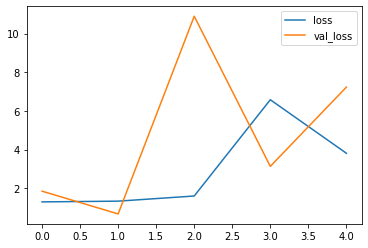

6/6 [==============================] - 0s 4ms/step
------------------------------
7.230006172942619
Accuracy: 66.67
------------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               1264400   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 1,364,902
Trainable params: 1,364,902
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
veinModel = Sequential()

veinModel.add(Dense(400, activation='relu', input_dim=3160))
veinModel.add(Dense(200, activation='relu'))
veinModel.add(Dense(100, activation='relu'))
veinModel.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
veinModel.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy']) 

veinHistory=veinModel.fit(inputs_train, targets_train,
          epochs=5,
          batch_size=10,
          verbose=1,
          validation_data=(inputs_test, targets_test),                  
          callbacks=[plot_losses])

nochUnbekannterWert, score = veinModel.evaluate(inputs_test, targets_test, batch_size=1)

print('------------------------------')

print(nochUnbekannterWert)
print('Accuracy: %.2f' % (score*100))

print('------------------------------')
print(veinModel.summary())